In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.path import Path
from matplotlib.patches import Circle, ConnectionPatch
import numpy as np
import time
from collections import deque, defaultdict
import math
from networkx.drawing.nx_agraph import graphviz_layout
from sklearn import manifold
import pandas as pd

# Dataset

In [3]:
Graph = nx.nx_agraph.read_dot('./Dataset/LesMiserables.dot/LesMiserables.dot')
edge_list =[]
for e in Graph.edges():
    u,v = e
    edge_list.append((u,v))

node_list = []
for i in Graph.nodes():
    node_list.append(i)
    
print(len(edge_list))
print(len(node_list))

254
77


In [4]:
# def distances_matrix(self):
#     N = len(self.nodes)
#     D = np.ones((N, N)) * 10000  # initialize distances matrix
#     numbered_nodes = {node.number: node for node in self.nodes.values()}
#     numbered_edges = {(edge.node1.number, edge.node2.number): edge for edge in self.edges.values()}

#     for (i, j), edge in numbered_edges.items():
#         D[i, j] = int(edge.weight) if edge.weight else 1  # if no weights give path value
#         D[j, i] = D[i, j]  # symmetry!

#     # self loop
#     for i in range(N):
#         D[i, i] = 0

#     for k, knode in numbered_nodes.items():
#         for i, inode in numbered_nodes.items():
#             for j, jnode in numbered_nodes.items():
#                 if D[i,j] > D[i,k] + D[k,j]:
#                     D[i,j] = D[i,k] + D[k,j]
#                     D[j,i] = D[i,j]  # symmetry!

#     S = np.ones((N,N)) / (D + np.eye(N))   # add identity matrix to avoid division by zero

#     return S


def distances_matrix(G):
    N = len(G.nodes)
    D = np.ones((N, N)) * np.inf  

    for i, node_i in enumerate(G.nodes):
        for j, node_j in enumerate(G.nodes):
            try:
                D[i, j] = nx.shortest_path_length(G, node_i, node_j)
            except nx.NetworkXNoPath:
                continue

    for i in range(N):
        D[i, i] = 0
        
    S = 1 / (D + np.eye(N))   # add identity matrix to avoid division by zero

    return S

In [5]:
S = distances_matrix(Graph)
print(S)

[[1.         1.         0.5        ... 0.25       0.25       0.2       ]
 [1.         1.         1.         ... 0.33333333 0.33333333 0.25      ]
 [0.5        1.         1.         ... 0.33333333 0.33333333 0.25      ]
 ...
 [0.25       0.33333333 0.33333333 ... 1.         0.33333333 0.33333333]
 [0.25       0.33333333 0.33333333 ... 0.33333333 1.         0.25      ]
 [0.2        0.25       0.25       ... 0.33333333 0.25       1.        ]]


<p><b>Multidimensional Scaling (MDS):</b> MDS is a technique used for analyzing similarity or dissimilarity data. It attempts to model similarity or dissimilarity data as distances in a geometric spaces. The data can be ratings of similarity between objects, interaction frequencies of molecules, or trade indices between countries.</p>

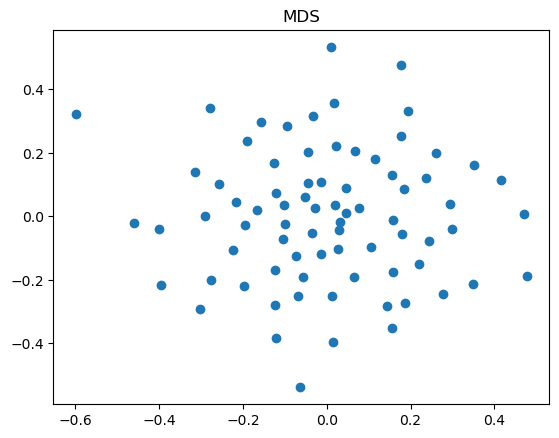

In [6]:
mds = manifold.MDS(n_components=2, dissimilarity="precomputed", random_state=6)
results = mds.fit(S)
coords = results.embedding_

plt.subplots_adjust(bottom = 0.1)
plt.scatter(coords[:, 0], coords[:, 1], marker = 'o')
plt.title('MDS')
plt.show()

<p><b>t-Distributed Stochastic Neighbor Embedding (t-SNE):</b> t-SNE is a machine learning algorithm for visualization developed by Laurens van der Maaten and Geoffrey Hinton. It is a nonlinear dimensionality reduction technique that is particularly well-suited for embedding high-dimensional data into a space of two or three dimensions, which can then be visualized in a scatter plot.  The technique can be broken down into two main components:<br>
 <ul>
     <li><b>Stochastic Neighbor Embedding (SNE):</b> SNE starts by converting the high-dimensional Euclidean distances between data points into conditional probabilities that represent similarities. The similarity of datapoint \\(x_j\\) to datapoint \\(x_i\\) is the conditional probability, \\(p_{j∣i}\\), that \\(x_i\\) would pick \\(x_j\\) as its neighbor if neighbors were picked in proportion to their probability density under a Gaussian centered at \\(x_i\\).</li>
     <li><b>t-Distribution:</b> The t-Distribution is used to compute the similarity of two points in the low-dimensional space. The use of the t-Distribution alleviates both the crowding problem and the optimization problem of SNE.</li>
 </ul>
 The t-SNE algorithm iteratively minimizes the divergence between the distributions \\(p_{j∣i}\\) in the high-dimensional space and the distributions \\(q_{j∣i}\\) in the low-dimensional space to find the best low-dimensional representation of the data.<br>
The main advantage of t-SNE is its ability to preserve local structure, meaning that instances that are close in the original space are likely to be close in the embedded space. This makes t-SNE particularly good at creating a single map that reveals structure at many different scales, which is particularly useful for visualizing complex real-world data.<br>
While t-SNE excels at creating intuitive visualizations, the axes of a t-SNE plot don’t have any interpretable meaning. In other words, it’s not generally possible to say what a movement along the x or y axis in the plot corresponds to in the original high-dimensional data space.
</p>

C:\Users\masou\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\masou\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\masou\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


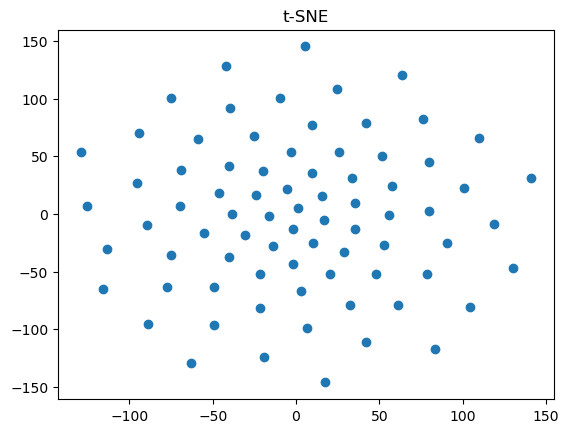

In [7]:
tsne = manifold.TSNE(n_components=2, random_state=0, metric='precomputed')
np.set_printoptions(suppress=True)
Y = tsne.fit_transform(S)

plt.scatter(Y[:, 0], Y[:, 1], marker = 'o')
plt.title('t-SNE')
plt.show()

<p><b>Isomap:</b> Isomap is a nonlinear dimensionality reduction method. It is one of several widely used low-dimensional embedding methods. Isomap begins by constructing a neighborhood network. After that, it uses graph distance to approximate the geodesic distance between all pairs of points. Finally, it uses classical multidimensional scaling to construct a d-dimensional Euclidean coordinate system in which the distances between points reflect the geodesic distances between points.</p>

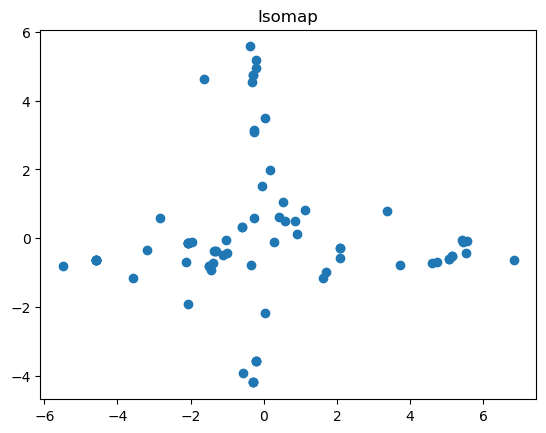

In [8]:
iso = manifold.Isomap(n_neighbors=6, n_components=2)
iso.fit(S)
manifold_2Da = iso.transform(S)
manifold_2D = pd.DataFrame(manifold_2Da, columns=['Component 1', 'Component 2'])

plt.scatter(manifold_2D['Component 1'], manifold_2D['Component 2'], marker = 'o')
plt.title('Isomap')
plt.show()

# After changing the parameters

C:\Users\masou\anaconda3\lib\site-packages\sklearn\manifold\_mds.py:517: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(
C:\Users\masou\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


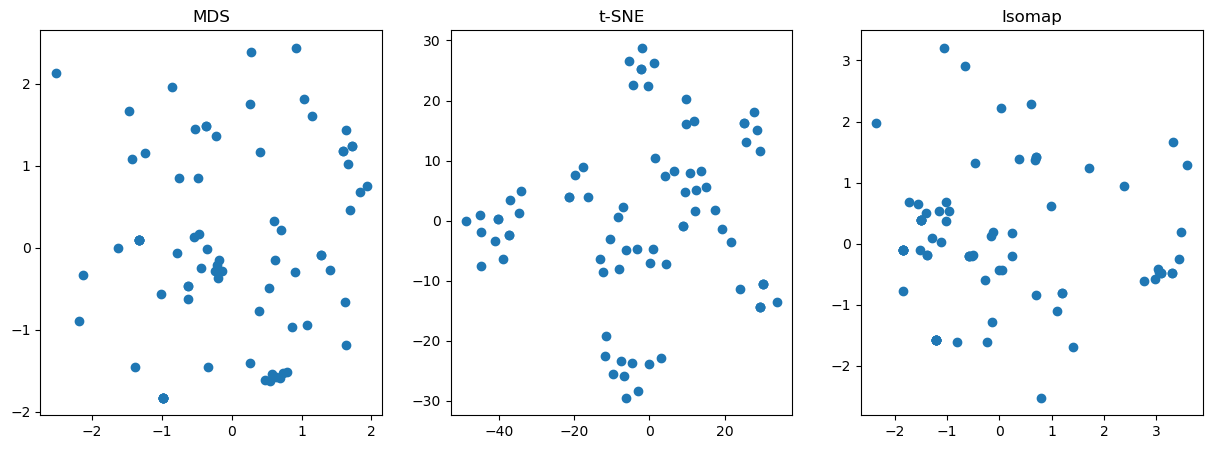

In [42]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# MDS
mds = manifold.MDS(n_components=2, dissimilarity="euclidean", random_state=6)
results = mds.fit(S)
coords = results.embedding_
axs[0].scatter(coords[:, 0], coords[:, 1], marker = 'o')
axs[0].set_title('MDS')

# t-SNE with adjusted parameters
tsne = manifold.TSNE(n_components=2, perplexity=10, learning_rate=1, random_state=0, metric='euclidean')
Y = tsne.fit_transform(S)
axs[1].scatter(Y[:, 0], Y[:, 1], marker = 'o')
axs[1].set_title('t-SNE')

# ISOMAP with adjusted parameters
iso = manifold.Isomap(n_neighbors=15, n_components=2)
iso.fit(S)
manifold_2Da = iso.transform(S)
axs[2].scatter(manifold_2Da[:, 0], manifold_2Da[:, 1], marker = 'o')
axs[2].set_title('Isomap')

# Show the plot
plt.show()
